In [1]:
from raise_utils.interpret import DODGEInterpreter
from raise_utils.interpret.sk import Rx
from matplotlib import pyplot as plt
import seaborn as sns
import re
import pickle

## Time results

In [2]:
from raise_utils.interpret.sk import Rx
from statistics import median
from typing import Union, Callable
import numpy as np


class DODGEInterpreter:
    """Interprets the results of DODGE-generated files"""

    def __init__(self, files=None, max_by: Union[None, int, Callable[..., str]] = None,
                 exclude_cols=None, metrics=None) -> None:
        """
        Initializes the interpreter.

        :param files - A list of files to be interpreted.
        :param max_by - Either a None, int, or Callable. If None, defaults to
                        maximizing the first entry, the metric maximized by DODGE.
                        If int, maximizes by the index specified.
                        If callable, maximizes by the function passed.
        :param exclude_cols - List of column indices to exclude
        :param metrics - List of metrics passed to DODGE. If excluding columns,
                        do NOT include these in this list.
        :return DODGEInterpreter object
        """
        if files is None:
            files = []
        if exclude_cols is None:
            exclude_cols = []
        if metrics is None:
            metrics = []
        self.files = files
        if max_by is None:
            self.max_by = 0
        else:
            self.max_by = max_by
        self.exclude_cols = exclude_cols
        self.metrics = metrics

    def interpret(self) -> dict:
        DODGE_ITER = 30
        medians = {}

        for file in self.files:
            with open(file, 'r') as f:
                lines = f.readlines()

            lines = [eval(line.split(':')[1])
                     for line in lines if line.startswith('iter')]

            n_runs = int(len(lines) // DODGE_ITER)
            n_metrics = len(lines[0]) - len(self.exclude_cols)

            if len(self.metrics) == 0:
                self.metrics = list(range(n_metrics))
            elif len(self.metrics) != n_metrics:
                raise ValueError("Passed list of metrics has size", len(self.metrics),
                                 "but file metrics (excluding exclude_cols) has size",
                                 n_metrics)

            lines = np.array(lines)
            lines = np.delete(lines, self.exclude_cols, -1)

            assert lines.shape == (n_runs * DODGE_ITER, n_metrics)

            run_splits = lines.reshape(
                (n_runs, DODGE_ITER, n_metrics))

            if isinstance(self.max_by, int):
                mapped_vals = np.apply_along_axis(
                    lambda x: x[self.max_by], axis=-1, arr=run_splits)
            elif callable(self.max_by):
                mapped_vals = np.apply_along_axis(
                    self.max_by, axis=-1, arr=run_splits)

            assert mapped_vals.shape == (n_runs, DODGE_ITER)

            max_idx = np.argmax(mapped_vals, axis=-1)

            medians[file.split('/')[-1]] = {metric: max_idx.choose(np.rollaxis(np.apply_along_axis(lambda p: p[i], -1, run_splits), -1, 0))
                                            for i, metric in enumerate(self.metrics)}

        return medians

In [3]:
def get_dodge_results(filename):
    interpret = DODGEInterpreter(files=[filename], max_by=0, metrics=["d2h", "f1", "pd", "pf", "prec"])
    results = interpret.interpret()
    
    with open(filename, 'r') as f:
        lines = f.readlines()
        time = float(lines[-1].split()[2])
    return round(time, 2), results[filename.split('/')[-1]]['d2h']

In [17]:
def get_hyperopt_results(filename):
    with open(f'./uci/hyperopt-log/{filename}.csv.txt', 'r') as f:
        lines = f.readlines()
        
        # Sanity check
        #if not lines[-2].strip().endswith('seconds.'):
        #    return None, None
        
        time = np.median([round(float(x.split()[2]), 2) for x in lines if x.startswith('Completed in')])
        
        # Search for performance
        perfs = [round(float(x.split(':')[1]), 2) for x in lines if x.startswith('perf')]
        return (round(time, 2), perfs)

In [5]:
def get_filename(dataset, time_period, alg):
    return f'./uci/{alg}-log/{dataset}-{time_period}.txt'

In [6]:
directories = ["1 day", "7 days", "14 days",
                "30 days", "90 days", "180 days", "365 days"]
datasets = ["camel", "cloudstack", "cocoon", "hadoop",
            "deeplearning", "hive", "node", "ofbiz", "qpid"]

In [45]:
header = f'| {"Dataset":<12} | {"Close time":<15} | {"DODGE Time":<10} | {"Hyperopt Time":<15} | {"DODGE Perf":<10} | {"Hyperopt Perf":<15} | {"Result":<10} |'
print('-' * len(header))
print(header)
print('=' * len(header))

wins = 0
ties = 0
losses = 0
i = 0

for dataset in datasets:
    for time_period in directories:
        dodge_time, dodge_perf = get_dodge_results(get_filename(dataset, time_period, 'dodge'))
        hyperopt_time, hyperopt_perf = get_hyperopt_results(i)
        
        if hyperopt_time is not None:
            data = {'dodge': dodge_perf, 'hyperopt': hyperopt_perf}
            sk = Rx.sk(Rx.data(**data))

            result = "WIN"

            if sk[0].rx == 'dodge':
                if sk[1].rank > sk[0].rank:
                    # Loss
                    losses += 1
                    result = "LOSS"
                elif sk[1].rank == sk[0].rank:
                    ties += 1
                    result = "TIE"
            else:
                if sk[1].rank > sk[0].rank:
                    wins += 1
                elif sk[1].rank == sk[0].rank:
                    ties += 1
                    result = "TIE"
            
            print(f'| {dataset:<12} | {time_period:<15} | {dodge_time:<10} | {hyperopt_time:<15} | {round(np.median(dodge_perf), 2):<10} | {round(np.median(hyperopt_perf), 2):<15} | {result:<10} |')
        
        i += 1
            
    print('-' * len(header))

print()
print('Summary:')
print('========')
print(f'{"Wins:":<10}{wins} = {round(wins/63*100, 2)}%')
print(f'{"Ties:":<10}{ties} = {round(ties/63*100, 2)}%')
print(f'{"Losses:":<10}{losses} = {round(losses/63*100, 2)}%')

-------------------------------------------------------------------------------------------------------------
| Dataset      | Close time      | DODGE Time | Hyperopt Time   | DODGE Perf | Hyperopt Perf   | Result     |
| camel        | 1 day           | 63.34      | 261.13          | 0.57       | 0.45            | WIN        |
| camel        | 7 days          | 105.33     | 252.24          | 0.49       | 0.24            | WIN        |
| camel        | 14 days         | 108.38     | 244.3           | 0.42       | 0.14            | WIN        |
| camel        | 30 days         | 151.13     | 267.32          | 0.4        | 0.18            | WIN        |
| camel        | 90 days         | 144.57     | 243.48          | 0.43       | 0.29            | WIN        |
| camel        | 180 days        | 98.56      | 246.3           | 0.53       | 0.48            | WIN        |
| camel        | 365 days        | 112.57     | 313.24          | 0.55       | 0.59            | LOSS       |
----------

# Defect prediction

In [15]:
def get_filename(dataset):
    return f'./uci/hyperopt-log/{dataset}.csv.txt'

In [13]:
def get_pickled_dodge_results(filename):
    with open(f'../../Dodge/dump/UCI/d2h_{filename}.pickle', 'rb') as f:
        data = pickle.load(f)
    
    time = data['time']
    time /= (4 * len(data['counter_full'][0.2]) / 30)
    
    return round(time/20, 2), [1. / np.sqrt(2) - x for x in data['counter_full'][0.2][29]]

In [30]:
files = ['camel', 'ivy', 'jedit', 'lucene', 'xalan', 'xerces', 'poi', 'log4j', 'synapse', 'velocity']

In [35]:
header = f'| {"Dataset":<12} | {"DODGE Time":<10} | {"Hyperopt Time":<15} | {"DODGE Perf":<10} | {"Hyperopt Perf":<15} | {"DODGE > Hyperopt":<17} |'
print('-' * len(header))
print(header)
print('=' * len(header))

wins = 0
ties = 0
losses = 0
undefined = 0

for dataset in files:
    dodge_time, dodge_perf = get_pickled_dodge_results(dataset)
    hyperopt_time, hyperopt_perf = get_hyperopt_results(dataset)
    
    if None in hyperopt_perf:
        print(f'| {dataset:<12} | {dodge_time:<10} | {"DNF":<15} | {round(np.median(dodge_perf), 2):<10} | {"DNF":<15} | {"N/A":<17} |')
        continue
    
    data = {'dodge': dodge_perf, 'hyperopt': hyperopt_perf}
    sk = Rx.sk(Rx.data(**data))
    
    result = "WIN"
    
    if sk[0].rx == 'dodge':
        if sk[1].rank > sk[0].rank:
            # Loss
            losses += 1
            result = "LOSS"
        elif sk[1].rank == sk[0].rank:
            ties += 1
            result = "TIE"
    else:
        if sk[1].rank > sk[0].rank:
            wins += 1
        elif sk[1].rank == sk[0].rank:
            ties += 1
            result = "TIE"
    
    print(f'| {dataset:<12} | {dodge_time:<10} | {hyperopt_time:<15} | {round(np.median(dodge_perf), 2):<10} | {round(np.median(hyperopt_perf), 2):<15} | {result:<17} |')

print('-' * len(header))
print()
print('Summary:')
print('========')
print(f'{"Wins:":<10}{wins} = {round(wins*10, 2)}%')
print(f'{"Ties:":<10}{ties} = {round(ties*10, 2)}%')
print(f'{"Losses:":<10}{losses} = {round(losses*10, 2)}%')
print(f'{"Undefined:":<10}{undefined} = {round(undefined*10, 2)}%')

--------------------------------------------------------------------------------------------------
| Dataset      | DODGE Time | Hyperopt Time   | DODGE Perf | Hyperopt Perf   | DODGE > Hyperopt  |
| camel        | 18.56      | 81.62           | 0.07       | 0.21            | LOSS              |
| ivy          | 15.51      | 26.63           | 0.25       | 0.14            | WIN               |
| jedit        | 17.31      | 63.87           | 0.31       | 0.31            | LOSS              |
| lucene       | 15.88      | 31.54           | 0.33       | 0.31            | WIN               |
| xalan        | 19.18      | 66.91           | 0.26       | 0.35            | LOSS              |
| xerces       | 16.8       | 35.18           | 0.01       | 0.27            | LOSS              |
| poi          | 17.65      | 52.03           | 0.34       | 0.36            | LOSS              |
| log4j        | 15.8       | 22.23           | 0.19       | 0.19            | TIE               |
| synapse 

# Code smell detection

In [27]:
header = f'| {"Dataset":<12} | {"DODGE Time":<10} | {"Hyperopt Time":<15} | {"DODGE Perf":<10} | {"Hyperopt Perf":<15} | {"DODGE > Hyperopt":<17} |'
print('-' * len(header))
print(header)
print('=' * len(header))

wins = 0
ties = 0
losses = 0

for dataset in ['DataClass', 'GodClass', 'FeatureEnvy', 'LongMethod']:
    dodge_time, dodge_perf = get_pickled_dodge_results(dataset)
    hyperopt_time, hyperopt_perf = get_hyperopt_results(dataset + '.csv')
        
    data = {'dodge': dodge_perf, 'hyperopt': hyperopt_perf}
    sk = Rx.sk(Rx.data(**data))
    
    result = "WIN"
    
    if sk[0].rx == 'dodge':
        if sk[1].rank > sk[0].rank:
            # Loss
            losses += 1
            result = "LOSS"
        elif sk[1].rank == sk[0].rank:
            ties += 1
            result = "TIE"
    else:
        if sk[1].rank > sk[0].rank:
            wins += 1
        elif sk[1].rank == sk[0].rank:
            ties += 1
            result = "TIE"
    
    print(f'| {dataset:<12} | {dodge_time:<10} | {hyperopt_time:<15} | {round(np.median(dodge_perf), 2):<10} | {round(np.median(hyperopt_perf), 2):<15} | {result:<17} |')

print('-' * len(header))
print()
print('Summary:')
print('========')
print(f'{"Wins:":<10}{wins} = {round(wins*25, 2)}%')
print(f'{"Ties:":<10}{ties} = {round(ties*25, 2)}%')
print(f'{"Losses:":<10}{losses} = {round(losses*25, 2)}%')

--------------------------------------------------------------------------------------------------
| Dataset      | DODGE Time | Hyperopt Time   | DODGE Perf | Hyperopt Perf   | DODGE > Hyperopt  |
| DataClass    | 44.78      | 133.08          | 0.32       | 0.28            | WIN               |
| GodClass     | 43.35      | 138.69          | 0.68       | 0.67            | TIE               |
| FeatureEnvy  | 47.38      | 135.59          | 0.71       | 0.71            | LOSS              |
| LongMethod   | 63.03      | 147.25          | 0.34       | 0.38            | LOSS              |
--------------------------------------------------------------------------------------------------

Summary:
Wins:     1 = 25%
Ties:     1 = 25%
Losses:   2 = 50%


# Text mining

In [15]:
header = f'| {"Dataset":<12} | {"DODGE Time":<10} | {"Hyperopt Time":<15} | {"DODGE Perf":<10} | {"Hyperopt Perf":<15} | {"DODGE > Hyperopt":<17} |'
print('-' * len(header))
print(header)
print('=' * len(header))

wins = 0
ties = 0
losses = 0

for dataset in ['pitsA', 'pitsB', 'pitsC', 'pitsD', 'pitsE', 'pitsF']:
    dodge_time, dodge_perf = get_pickled_dodge_results(dataset)
    hyperopt_time, hyperopt_perf = get_hyperopt_results(dataset)
        
    data = {'dodge': dodge_perf, 'hyperopt': hyperopt_perf}
    sk = Rx.sk(Rx.data(**data))
    
    result = "WIN"
    
    if sk[0].rx == 'dodge':
        if sk[1].rank > sk[0].rank:
            # Loss
            losses += 1
            result = "LOSS"
        elif sk[1].rank == sk[0].rank:
            ties += 1
            result = "TIE"
    else:
        if sk[1].rank > sk[0].rank:
            wins += 1
        elif sk[1].rank == sk[0].rank:
            ties += 1
            result = "TIE"
    
    print(f'| {dataset:<12} | {dodge_time:<10} | {hyperopt_time:<15} | {round(np.median(dodge_perf), 2):<10} | {round(np.median(hyperopt_perf), 2):<15} | {result:<17} |')

print('-' * len(header))
print()
print('Summary:')
print('========')
print(f'{"Wins:":<10}{wins} = {round(wins/6*100, 2)}%')
print(f'{"Ties:":<10}{ties} = {round(ties/6*100, 2)}%')
print(f'{"Losses:":<10}{losses} = {round(losses/6*100, 2)}%')

--------------------------------------------------------------------------------------------------
| Dataset      | DODGE Time | Hyperopt Time   | DODGE Perf | Hyperopt Perf   | DODGE > Hyperopt  |
| pitsA        | 494.67     | 289.61          | 0.25       | 0.48            | LOSS              |
| pitsB        | 494.45     | 155.02          | 0.0        | 0.71            | LOSS              |
| pitsC        | 135.62     | 155.1           | 0.62       | 0.65            | LOSS              |
| pitsD        | 96.92      | 137.41          | 0.46       | 0.44            | WIN               |
| pitsE        | 349.19     | 236.74          | 0.49       | 0.37            | WIN               |
| pitsF        | 268.53     | 210.94          | 0.27       | 0.46            | LOSS              |
--------------------------------------------------------------------------------------------------

Summary:
Wins:     2 = 33.33%
Ties:     0 = 0.0%
Losses:   4 = 66.67%


## UCI

In [8]:
import glob

In [25]:
header = f'| {"Dataset":<17} | {"DODGE Time":<10} | {"Hyperopt Time":<15} | {"DODGE Perf":<10} | {"Hyperopt Perf":<15} | {"DODGE > Hyperopt":<17} |'
print('-' * len(header))
print(header)
print('=' * len(header))

wins = 0
ties = 0
losses = 0

tmp = []

files = [x.split('/')[-1].split('.')[0] for x in glob.glob('../../Dodge/data/UCI/*.csv')]

for dataset in files:
    dodge_time, dodge_perf = get_pickled_dodge_results(dataset)
    hyperopt_time, hyperopt_perf = get_hyperopt_results(dataset)
        
    data = {'dodge': dodge_perf, 'hyperopt': hyperopt_perf}
    sk = Rx.sk(Rx.data(**data))
    
    result = "WIN"
    
    if sk[0].rx == 'dodge':
        if sk[1].rank > sk[0].rank:
            # Loss
            losses += 1
            result = "LOSS"
        elif sk[1].rank == sk[0].rank:
            ties += 1
            result = "TIE"
    else:
        if sk[1].rank > sk[0].rank:
            wins += 1
        elif sk[1].rank == sk[0].rank:
            ties += 1
            result = "TIE"
    
    tmp.append(0 if result == "LOSS" else 1)
    
    print(f'| {dataset:<17} | {dodge_time:<10} | {hyperopt_time:<15} | {round(np.median(dodge_perf), 2):<10} | {round(np.median(hyperopt_perf), 2):<15} | {result:<17} |')

print('-' * len(header))
print()
print('Summary:')
print('========')
print(f'{"Wins:":<10}{wins} = {round(wins/len(files)*100, 2)}%')
print(f'{"Ties:":<10}{ties} = {round(ties/len(files)*100, 2)}%')
print(f'{"Losses:":<10}{losses} = {round(losses/len(files)*100, 2)}%')

-------------------------------------------------------------------------------------------------------
| Dataset           | DODGE Time | Hyperopt Time   | DODGE Perf | Hyperopt Perf   | DODGE > Hyperopt  |
| credit-approval   | 7.92       | 37.42           | 0.63       | 0.56            | WIN               |
| cervical-cancer   | 8.64       | 19.44           | 0.6        | 0.52            | WIN               |
| cardiotocography  | 10.12      | 48.62           | 0.63       | 0.68            | LOSS              |
| adult             | 38.93      | 234.39          | 0.46       | 0.44            | WIN               |
| bank              | 9.43       | 32.34           | 0.46       | 0.5             | LOSS              |
| autism            | 7.94       | 14.08           | 0.67       | 0.71            | LOSS              |
| sensorless-drive  | 25.41      | 91.13           | 0.71       | 0.71            | LOSS              |
| htru2             | 13.61      | 107.23          | 0.66       

In [29]:
print('\n'.join([str(x) for x in tmp]))

1
1
0
1
0
0
0
1
1
0
0
1
0
1
1
1
1
0
1
0
0
0
0
0
0
0
1
1
0
0
1
0
1
0
0
1
0


# Overall

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('./dim-vs-wins.csv')

In [3]:
df

,Dataset,Dimensionality,Win
0,deeplearning,1.9,1
1,deeplearning,1.9,1
2,deeplearning,1.9,1
3,deeplearning,1.9,1
4,deeplearning,1.9,1
...,...,...,...
89,shop-intention,1.6,0
90,crowdsource,5.2,0
91,diabetic,1.8,0
92,blood-transfusion,1.2,1


In [4]:
import numpy as np

In [5]:
x = np.linspace(df["Dimensionality"].min()-0.5, df["Dimensionality"].max()+1., 500)
y = [sum((df["Dimensionality"] <= t) & (df["Win"] == 1)) / len(df["Dimensionality"] <= t) for t in x]

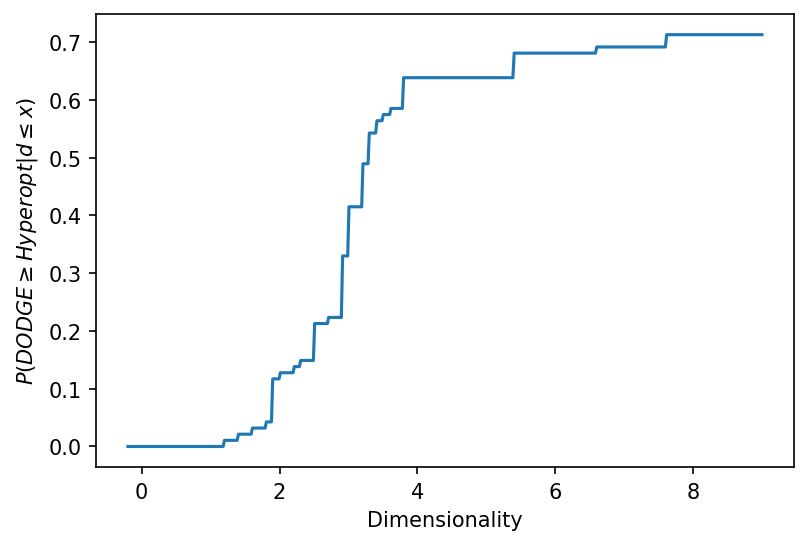

In [6]:
plt.figure(dpi=150, facecolor="white")
plt.xlabel("Dimensionality")
plt.ylabel("$P(DODGE \geq Hyperopt | d \leq x)$")
plt.plot(x, y);